In [17]:
import pandas as pd
import io
import requests
import numpy as np
import collections
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
dt = pd.read_csv('C:/Users/Owner/Documents/Sac State/CSC215_P2_Stock_Price.csv')
dt['Close_y'] = dt['Close']
split = int(0.7 * len(dt))
df_train = dt[:split]
df_test = dt[split:len(dt)]

print("Training set has {} records.".format(len(df_train)))
print("Test set has {} records.".format(len(df_test)))


Training set has 3074 records.
Test set has 1318 records.


Since we want to ensure time-based relationships between observations, we split the data in a sequential way. The first 70% of observations are in the training set, with the remaining in our test.
Additoinally, we create a new column 'Close_y' to preserve the actual observed closing values. This will be used as our dependent variable. This column is needed as the 'Close' column will be used as an input variable and will be normalized.

In [33]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
        
    if sd is None:
        sd = df[name].std()
        
    df[name] = (df[name] - mean) / sd

normal_list = ['Open', 'High', 'Low', 'Volume', 'Close'];

for element in normal_list:
    encode_numeric_zscore(df_train, element)
    encode_numeric_zscore(df_test, element)    



params_train = df_train[['Open', 'High', 'Low', 'Volume', 'Close']].values.tolist()
params_test = df_test[['Open', 'High', 'Low', 'Volume', 'Close',]].values.tolist()

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next we normalize the values, and drop the 'date' column from the dataframe. The way we did this caused a warning, however this does not impact our final program.

In [40]:
def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,params_train)
obs_train = df_train['Close_y'][SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_train.pop()
obs_train = np.asarray(obs_train)

x_test,y_test = to_sequences(SEQUENCE_SIZE,params_test)
obs_test = df_test['Close_y'][SEQUENCE_SIZE:len(close_train)].values.tolist()
obs_test.pop()
obs_test = np.asarray(obs_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(obs_train.shape))
print("Shape of y_test: {}".format(obs_test.shape))

Shape of x_train: (3066, 7, 5)
Shape of x_test: (1310, 7, 5)
Shape of y_train: (3066,)
Shape of y_test: (1310,)


Here we transform our data in sequence data. Now, each record is a sequence of 7 days of data, each with 5 relevant pieces of information on that day's market behavior. Additionally, there is one dependent variable for each of these 7x5 structures which holds the close price of the stock on the seventh day.

In [74]:
myDict = dict()
##activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for opt in optimizerType:
    ##checkpointer = ModelCheckpoint(filepath="best_weights3.hdf5", verbose=0, save_best_only=True) # save best model        
    ##for i in range(2):
        ##print(i)        
        # Build network
        model = Sequential()
        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 5)))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)        
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
        model.fit(x_train,obs_train,validation_data=(x_test,obs_test), callbacks=[monitor],verbose=2, epochs=100)  


    ##print('Training finished...Loading the best model')  
    ##print()
    ##model.load_weights("best_weights3.hdf5") # load weights from best model
        myDict.update({iteration : (opt, model)})
        iteration += 1

Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 20s - loss: 117.7427 - val_loss: 2886.6912
Epoch 2/100
3066/3066 - 18s - loss: 3.7830 - val_loss: 2945.3632
Epoch 3/100
3066/3066 - 13s - loss: 2.8872 - val_loss: 2953.1208
Epoch 4/100
3066/3066 - 14s - loss: 2.2651 - val_loss: 2955.1328
Epoch 5/100
3066/3066 - 17s - loss: 2.0222 - val_loss: 2982.1990
Epoch 6/100
3066/3066 - 18s - loss: 1.8070 - val_loss: 3037.9072
Epoch 00006: early stopping
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 19s - loss: 15.2922 - val_loss: 2666.4808
Epoch 2/100
3066/3066 - 13s - loss: 3.1264 - val_loss: 3302.3768
Epoch 3/100
3066/3066 - 15s - loss: 2.3446 - val_loss: 3022.2317
Epoch 4/100
3066/3066 - 13s - loss: 2.1009 - val_loss: 2983.4248
Epoch 5/100
3066/3066 - 13s - loss: 2.3565 - val_loss: 3129.2285
Epoch 6/100
3066/3066 - 14s - loss: 1.8340 - val_loss: 2838.5252
Epoch 00006: early stopping


Here we use checkpointing and earlystopping to iteration through model construction. Checkpointing allows us to save our best model whereas earlystopping will stop training after the model reaches a certain point on the descent algorithm. 

Analyzing model with optimizer adam


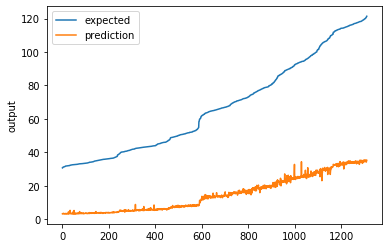

Score (RMSE): 55.1172133130421
Analyzing model with optimizer sgd


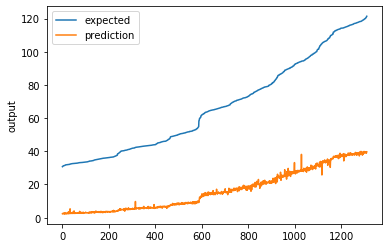

Score (RMSE): 53.27781188886791


In [75]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

Here we see that both models have a very similar RMSE (implying the optimizer makes little to no difference). Additionally, we see the reression lift chart. We find it a bit odd that there seems to be a relatively consistent linear gap between the expected and the prediction. In other words, it seems odd that our predictions seem to attempt to match the slope of the expected but the y intercept is off by about 20. We assume that this it because we split the data in a linear way

Analyzing model with optimizer adam


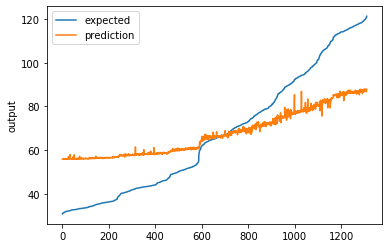

Score (RMSE): 17.394533365517937
Analyzing model with optimizer sgd


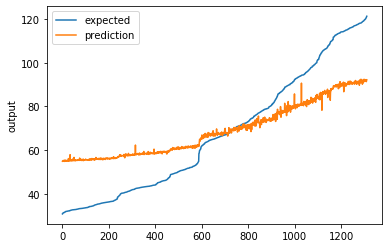

Score (RMSE): 15.879691858016981


In [76]:
for ele in myDict.values():
    print('Analyzing model with optimizer {}'.format(ele[0]))
    model = ele[1]
    pred = model.predict(x_test)
    pred = pred + np.mean(obs_test) - np.mean(obs_train)
    obs_test = np.asarray(obs_test)
    score = np.sqrt(metrics.mean_squared_error(pred,obs_test))
    chart_regression(pred,obs_test)
    print("Score (RMSE): {}".format(score))

In [64]:
###Fully Connected NN
test_NN = []
for ele in x_test:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    test_NN.append(flat_list)

train_NN = []
for ele in x_train:
    flat_list = []
    for sublist in ele:
        for item in sublist:
            flat_list.append(item)
    train_NN.append(flat_list)


train_NN = pd.DataFrame(train_NN)
train_NN['out'] = obs_train
test_NN = pd.DataFrame(test_NN)
test_NN['out'] = obs_test


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


train_NN,y_train2 = to_xy(train_NN, 'out')
test_NN, y_test2 = to_xy(test_NN, 'out')

Moving on to the fully connected neural network. We need to do some data wrangling. First off, we need to change the data from 7 day sequence of 5 fields into a 35 field record. Then, we need to do some structure formatting to interface with tensorflow. After doing preprocessing, we are ready for model building.

In [65]:

myDict2 = dict()
activationType = ['relu', 'sigmoid', 'tanh']
optimizerType = ['adam', 'sgd']
iteration = 0

for act in activationType:
    for opt in optimizerType:
        checkpointer2 = ModelCheckpoint(filepath="C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model
        
        for i in range(5):
            print(i)
            model_NN = Sequential()
            model_NN.add(Dense(20, input_dim=train_NN.shape[1], activation=act))
            model_NN.add(Dense(1))
            model_NN.compile(loss='mean_squared_error', optimizer=opt)        
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')        
            model_NN.fit(train_NN,y_train2,validation_data=(test_NN,y_test2),callbacks=[monitor, checkpointer2],verbose=2,epochs=100)

        print('Training finished...Loading the best model')  
        print()
        model_NN.load_weights("C:/Users/Owner/Documents/Sac State/csc215/proj2/best_weights2.hdf5") # load weights from best model
        myDict2.update({iteration : (act, opt, model_NN)})
        iteration += 1


0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 10s - loss: 226.1803 - val_loss: 4395.0215
Epoch 2/100
3066/3066 - 0s - loss: 85.9256 - val_loss: 3727.6223
Epoch 3/100
3066/3066 - 0s - loss: 46.1978 - val_loss: 3532.2939
Epoch 4/100
3066/3066 - 0s - loss: 41.6651 - val_loss: 3469.4702
Epoch 5/100
3066/3066 - 0s - loss: 38.0740 - val_loss: 3469.7446
Epoch 6/100
3066/3066 - 0s - loss: 33.6703 - val_loss: 3387.9872
Epoch 7/100
3066/3066 - 0s - loss: 28.8059 - val_loss: 3335.0447
Epoch 8/100
3066/3066 - 0s - loss: 24.2117 - val_loss: 3290.3351
Epoch 9/100
3066/3066 - 0s - loss: 19.7249 - val_loss: 3253.9698
Epoch 10/100
3066/3066 - 0s - loss: 15.6974 - val_loss: 3234.2001
Epoch 11/100
3066/3066 - 0s - loss: 12.0572 - val_loss: 3180.6107
Epoch 12/100
3066/3066 - 1s - loss: 8.7269 - val_loss: 3156.8696
Epoch 13/100
3066/3066 - 1s - loss: 6.2915 - val_loss: 3126.6447
Epoch 14/100
3066/3066 - 0s - loss: 4.3605 - val_loss: 3121.8643
Epoch 15/100
3066/3066 - 0s - loss: 

Epoch 35/100
3066/3066 - 0s - loss: 0.4035 - val_loss: 3061.6910
Epoch 36/100
3066/3066 - 0s - loss: 0.4010 - val_loss: 3060.4351
Epoch 37/100
3066/3066 - 0s - loss: 0.3801 - val_loss: 3055.9841
Epoch 38/100
3066/3066 - 0s - loss: 0.3607 - val_loss: 3051.9980
Epoch 39/100
3066/3066 - 0s - loss: 0.3487 - val_loss: 3066.7125
Epoch 00039: early stopping
3
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 6s - loss: 285.3322 - val_loss: 4746.4804
Epoch 2/100
3066/3066 - 0s - loss: 157.8800 - val_loss: 4152.9210
Epoch 3/100
3066/3066 - 0s - loss: 74.1156 - val_loss: 3721.5457
Epoch 4/100
3066/3066 - 0s - loss: 45.8218 - val_loss: 3497.9581
Epoch 5/100
3066/3066 - 0s - loss: 41.8216 - val_loss: 3485.0822
Epoch 6/100
3066/3066 - 0s - loss: 39.1887 - val_loss: 3465.9750
Epoch 7/100
3066/3066 - 0s - loss: 36.0519 - val_loss: 3478.1461
Epoch 8/100
3066/3066 - 0s - loss: 32.3615 - val_loss: 3455.9839
Epoch 9/100
3066/3066 - 0s - loss: 27.8255 - val_loss: 3406.2537
Epoch 10/1

Epoch 9/100
3066/3066 - 0s - loss: 5.0100 - val_loss: 3032.5547
Epoch 10/100
3066/3066 - 0s - loss: 4.0036 - val_loss: 2994.1882
Epoch 00010: early stopping
2
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 6s - loss: 98.7504 - val_loss: 2893.5392
Epoch 2/100
3066/3066 - 0s - loss: 31.5627 - val_loss: 3102.0995
Epoch 3/100
3066/3066 - 0s - loss: 23.2454 - val_loss: 4092.1106
Epoch 4/100
3066/3066 - 5s - loss: 18.1327 - val_loss: 2733.3300
Epoch 5/100
3066/3066 - 0s - loss: 6.4884 - val_loss: 2923.9292
Epoch 6/100
3066/3066 - 0s - loss: 1.7708 - val_loss: 3099.3253
Epoch 7/100
3066/3066 - 0s - loss: 13.1409 - val_loss: 3047.4903
Epoch 8/100
3066/3066 - 0s - loss: 4.5944 - val_loss: 3013.6305
Epoch 9/100
3066/3066 - 0s - loss: 3.2134 - val_loss: 3085.2997
Epoch 00009: early stopping
3
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 10s - loss: 117.4940 - val_loss: 2693.5023
Epoch 2/100
3066/3066 - 0s - loss: 11.4105 - val_loss: 3069.4368
Ep

Epoch 4/100
3066/3066 - 0s - loss: 185.5543 - val_loss: 4478.3091
Epoch 5/100
3066/3066 - 0s - loss: 160.3799 - val_loss: 4323.3080
Epoch 6/100
3066/3066 - 0s - loss: 137.0021 - val_loss: 4171.6629
Epoch 7/100
3066/3066 - 0s - loss: 116.3434 - val_loss: 4030.0712
Epoch 8/100
3066/3066 - 0s - loss: 99.2614 - val_loss: 3898.5062
Epoch 9/100
3066/3066 - 0s - loss: 83.0030 - val_loss: 3763.9883
Epoch 10/100
3066/3066 - 0s - loss: 68.9367 - val_loss: 3646.4634
Epoch 11/100
3066/3066 - 0s - loss: 58.3340 - val_loss: 3543.9853
Epoch 12/100
3066/3066 - 0s - loss: 49.9891 - val_loss: 3454.8218
Epoch 13/100
3066/3066 - 0s - loss: 43.4128 - val_loss: 3378.0085
Epoch 14/100
3066/3066 - 0s - loss: 38.1681 - val_loss: 3310.2885
Epoch 15/100
3066/3066 - 0s - loss: 33.9472 - val_loss: 3250.5966
Epoch 16/100
3066/3066 - 0s - loss: 30.4957 - val_loss: 3198.6198
Epoch 17/100
3066/3066 - 0s - loss: 27.6119 - val_loss: 3153.1262
Epoch 18/100
3066/3066 - 0s - loss: 25.1508 - val_loss: 3111.8122
Epoch 19/100

Epoch 35/100
3066/3066 - 0s - loss: 7.2585 - val_loss: 2937.8996
Epoch 36/100
3066/3066 - 0s - loss: 6.5820 - val_loss: 2929.8670
Epoch 37/100
3066/3066 - 0s - loss: 5.9594 - val_loss: 2932.6373
Epoch 38/100
3066/3066 - 0s - loss: 5.4046 - val_loss: 2922.0708
Epoch 39/100
3066/3066 - 0s - loss: 4.9262 - val_loss: 2932.2811
Epoch 40/100
3066/3066 - 0s - loss: 4.5012 - val_loss: 2944.5428
Epoch 41/100
3066/3066 - 0s - loss: 4.1198 - val_loss: 2926.9075
Epoch 42/100
3066/3066 - 0s - loss: 3.7880 - val_loss: 2934.6591
Epoch 43/100
3066/3066 - 0s - loss: 3.4892 - val_loss: 2933.8814
Epoch 00043: early stopping
Training finished...Loading the best model

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 11s - loss: 33.1064 - val_loss: 2804.9300
Epoch 2/100
3066/3066 - 0s - loss: 4.7177 - val_loss: 2855.5115
Epoch 3/100
3066/3066 - 0s - loss: 2.5579 - val_loss: 2871.4337
Epoch 4/100
3066/3066 - 0s - loss: 1.8565 - val_loss: 2908.0547
Epoch 5/100
3066/3066 - 0s - loss: 

Epoch 35/100
3066/3066 - 0s - loss: 3.1589 - val_loss: 3026.0075
Epoch 00035: early stopping
2
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 7s - loss: 309.3437 - val_loss: 5120.5398
Epoch 2/100
3066/3066 - 1s - loss: 275.8024 - val_loss: 4981.2297
Epoch 3/100
3066/3066 - 1s - loss: 240.7621 - val_loss: 4799.0202
Epoch 4/100
3066/3066 - 0s - loss: 200.9408 - val_loss: 4583.0651
Epoch 5/100
3066/3066 - 0s - loss: 161.4960 - val_loss: 4353.6041
Epoch 6/100
3066/3066 - 0s - loss: 127.2262 - val_loss: 4151.1192
Epoch 7/100
3066/3066 - 0s - loss: 99.8222 - val_loss: 3956.8502
Epoch 8/100
3066/3066 - 1s - loss: 79.1264 - val_loss: 3794.1781
Epoch 9/100
3066/3066 - 0s - loss: 63.8339 - val_loss: 3663.3688
Epoch 10/100
3066/3066 - 0s - loss: 52.6396 - val_loss: 3559.8981
Epoch 11/100
3066/3066 - 0s - loss: 44.4764 - val_loss: 3474.1914
Epoch 12/100
3066/3066 - 0s - loss: 38.4309 - val_loss: 3392.1262
Epoch 13/100
3066/3066 - 0s - loss: 33.7497 - val_loss: 3316.2312
Ep

Epoch 00039: early stopping
Training finished...Loading the best model

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 11s - loss: 66.1160 - val_loss: 3254.0571
Epoch 2/100
3066/3066 - 1s - loss: 10.5395 - val_loss: 2938.7594
Epoch 3/100
3066/3066 - 0s - loss: 5.4465 - val_loss: 3034.7007
Epoch 4/100
3066/3066 - 0s - loss: 5.0387 - val_loss: 3102.1878
Epoch 5/100
3066/3066 - 0s - loss: 4.6272 - val_loss: 2788.0715
Epoch 6/100
3066/3066 - 0s - loss: 3.4836 - val_loss: 2914.5234
Epoch 7/100
3066/3066 - 0s - loss: 2.3972 - val_loss: 2823.3878
Epoch 8/100
3066/3066 - 0s - loss: 2.9650 - val_loss: 3081.7474
Epoch 9/100
3066/3066 - 0s - loss: 2.3725 - val_loss: 2921.3108
Epoch 10/100
3066/3066 - 0s - loss: 2.5600 - val_loss: 3063.4178
Epoch 00010: early stopping
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
3066/3066 - 7s - loss: 60.3029 - val_loss: 2929.8742
Epoch 2/100
3066/3066 - 0s - loss: 8.5843 - val_loss: 2865.2340
Epoch 3/100
3066/3066 - 0s 

Similar to our LTSM, we use early stopping and model checkpointing to iterate (and avoid local optima) and save the weights to reference our best model. However, we are iterating through activation layer types as well as optimerizers. An observation about training these models is that they are much faster than the LTSM (in terms of training time per epoch). However, many more epochs are needed to reache the lost cutoff point.

Analyzing model with activation relu and optimizer adam


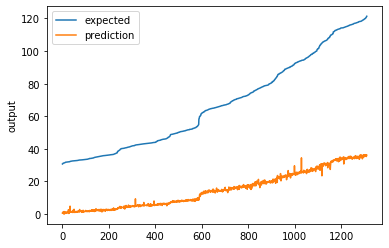

Score (RMSE): 55.03240619518123
Analyzing model with activation relu and optimizer sgd


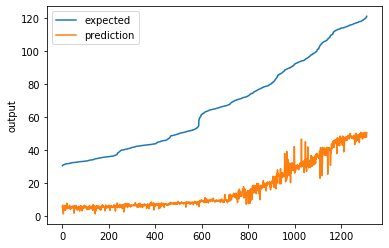

Score (RMSE): 51.89896233114662
Analyzing model with activation sigmoid and optimizer adam


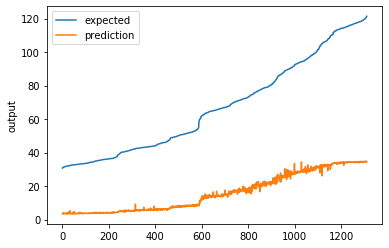

Score (RMSE): 54.00758581768669
Analyzing model with activation sigmoid and optimizer sgd


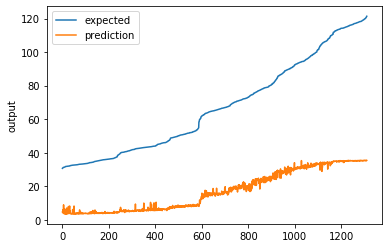

Score (RMSE): 52.75581428052243
Analyzing model with activation tanh and optimizer adam


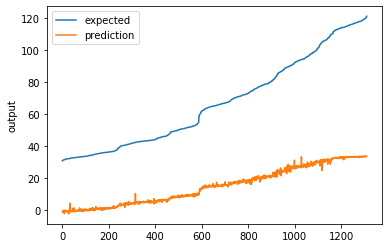

Score (RMSE): 54.9260297832994
Analyzing model with activation tanh and optimizer sgd


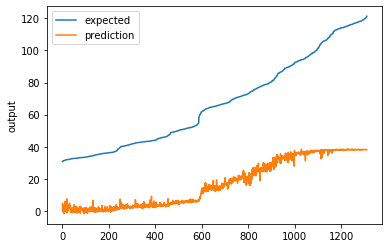

Score (RMSE): 51.991589815994665


In [66]:
for ele in myDict2.values():
    print('Analyzing model with activation {} and optimizer {}'.format(ele[0], ele[1]))
    model_NN = ele[2]
    pred_NN = model_NN.predict(test_NN)
       
    score_NN = np.sqrt(metrics.mean_squared_error(pred_NN,obs_test))
    chart_regression(pred_NN,obs_test)
    print("Score (RMSE): {}".format(score_NN))
    

# Need to rerun model building